In [1]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
import sqlite3
from sqlite3 import Error
import io
import base64
import numpy as np
from sklearn import preprocessing
from collections import Counter
import tensorflow as tf
from tensorflow.python.platform import gfile
from sklearn.svm import SVC
from sklearn.utils import shuffle
import pickle
import math
import time
import xlsxwriter
import random
from xlrd import open_workbook

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### UTILITY FUNCTIONS

In [2]:
def print_matrix(matrix, filename):
        
    workbook = xlsxwriter.Workbook(filename + '.xlsx')
    worksheet = workbook.add_worksheet()
        
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            worksheet.write(i, j , matrix[i][j])
            
    print("\t\tSAVED MATRIX TO: " + filename + '.xlsx')
    
    workbook.close()
            
    return None

In [3]:
def load_mat_from_excel(location):
    
    matrix = None
    
    workbook = open_workbook(location)
    worksheet = workbook.sheets()[0]
    
    n_rows = worksheet.nrows
    n_cols = worksheet.ncols
    
    mat = []
    
    for i in range(n_rows):
        row = []
        for j in range(n_cols):
            value = float(worksheet.cell(i,j).value)
            row.append(value)
        mat.append(np.array(row))
        
    mat = np.array(mat)
    
    print("\t\tLOADED MATRIX FROM: " + location + '.xlsx')
            
    return mat

In [4]:
def print_stats(dataset):
    
    min_count_levels = [400]
    stats = { '>400':0 }
    
    folders = os.listdir(dataset)[1:]
    file_lengths = []
    
    for i in range(len(folders) - 3):
        if i == len(folders) - 1:
            return
        _,_,files = next(os.walk(dataset + '/' + folders[i]))
        print("CHECKED FOLDERS: " + str(i+1) + '/' + str(len(folders)), end = '\r')
        file_lengths.append(len(files))

    #print(file_lengths)
    
    for min_count in min_count_levels:
        count = 0
        for length in file_lengths:
            if (length > min_count):
                stats[str('>' + str(min_count))] = stats[str('>' + str(min_count))] + 1
    
    return stats

In [5]:
def load_embeddings_from_file(file):
    
    embeddings, labels = np.array([]), np.array([])
    
    if (os.path.isfile(file)):
        print("LOADING EXISTING DATASET EMBEDDINGS: " + file)
        embeddings, labels = pickle.load(open(file, 'rb'))
        return embeddings, labels
        
    print("TARGETED SET EMBEDDINGS DO NOT EXIST: " + file)
    
    return embeddings, labels

In [115]:
ebds, labels = load_embeddings_from_file("Embeddings/MobileNet1.0_CASIA_train_800_100_100.pkl")

LOADING EXISTING DATASET EMBEDDINGS: Embeddings/MobileNet1.0_CASIA_train_800_100_100.pkl


In [117]:
ebds

array([[ 1.9198730e-13, -1.7407271e-14, -2.3520297e-13, ...,
         4.7347510e-13,  4.8260538e-13,  4.0251651e-13],
       [ 1.3812026e-13, -8.8670194e-14, -2.3680352e-13, ...,
         5.8790337e-13,  5.7716180e-13,  4.8534055e-13],
       [ 9.2758910e-14, -9.8263267e-15, -1.7403768e-13, ...,
         3.6586831e-13,  3.2381080e-13,  2.9951432e-13],
       ...,
       [ 2.2953159e-13, -9.0433052e-14, -3.6061361e-13, ...,
         8.6912910e-13,  8.8332217e-13,  7.6655983e-13],
       [ 2.7189446e-13, -9.4056185e-14, -4.7527786e-13, ...,
         9.5410930e-13,  9.0807879e-13,  7.7706689e-13],
       [ 3.1477495e-13, -1.6371708e-13, -4.3445784e-13, ...,
         9.5916634e-13,  8.8100631e-13,  8.5230504e-13]], dtype=float32)

In [6]:
def save_embeddings(embeddings, labels, destination):
    
    pickle.dump((embeddings, labels), open(destination + '.pkl', 'wb'))
    print("\t\tSAVED EMBEDDINGS + LABELS: " + destination + '.pkl')
    
    return None

In [45]:
def get_set_summary(labels):
    
    set_summary = []
    
    data = Counter(labels)
    le = preprocessing.LabelEncoder().fit(labels)
    set_summary = [len(labels), len(le.classes_), data.most_common()[-1][1], data.most_common()[0][1]]
    
    return set_summary

### 1. CREATE DATASETS

In [112]:
# 1.4

def fixed_standardize(x):
    
    #print(x)
    
    y = (x - 127.5) / 128
    
    #print(y)
    
    return y

In [7]:
# 1.3

def prewhiten(x):
    
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    
    return y  

In [8]:
# 1.2 B
# TODO: fix query so that there is an upper limit to image per subject (MED PRIORITY),
#       test set not loading (HIGH PRIORITY)

def process_database(conn, dataset, size, min_count, max_count):
    
    """
        INPUTS:
        
                 conn: sqlite3 db connection
              dataset: String ('train' || 'test')
                 size: int (required number of samples)
            min_count: int (minimum number of training images per subject)
            max_count: int (maximum number of training images per subject, default = 10)
        
        OUTPUTS:
        
            x: np.array(size, img_height, img_weight, 3)
            y: np.array(size,)
    
    """
    
    print("\t1.2B: LOADING " + dataset.upper() + " SET IMAGES FROM DATABASE")
    
    x, y = [], []
        
    cursor = conn.cursor()
        
    query = """SELECT i.person_id, i.image
    FROM ((datasets d
    INNER JOIN images i ON d.image_id = i.id)
    INNER JOIN people p ON i.person_id = p.id)
    WHERE d.name = ?
    GROUP BY i.person_id
    HAVING COUNT(i.image) > ?
    LIMIT ?;"""
     
    start = time.time() 
    
    cursor.execute(query, (set_type, min_count, size))   
    rows = cursor.fetchall()
    
    stop = time.time()
    
    print("\t1.2B: QUERIED " + str(len(rows)) + " TUPLES FROM DATABASE: " + str(stop - start)[:7] + " s")
    
    for i in range(len(rows)):
        image = Image.open(io.BytesIO(rows[i][1]))
        image = image.resize((160, 160), Image.ANTIALIAS)
        image_arr = np.array(image)
        label = int(rows[i][0])
        x.append(image_arr)
        y.append(label)
    
    cursor.close()
    
    """
    le = preprocessing.LabelEncoder().fit(y)
    n_classes = le.classes_
    target_status = " SET (TARGET SET SIZE NOT MET):"
    min_image_count = 1

    if (len(x) == size):
        target_status = " SET (TARGET SET SIZE MET):"
        
    if (dataset == 'train'):
        min_image_count = min_count
    
    print("\t1.2B: ADDED " + str(len(x)) + " SAMPLES TO " + dataset.upper() + target_status + "\n" +
          "\t\tIMAGE SHAPE: " + str(x[0].shape) + "\n" +
          "\t\tSUBJECT COUNT: " + str(len(le.classes_)) + "\n" +
          "\t\tMIN IMAGE COUNT PER SUBJECT: " + str(min_image_count) + "\n" +
          "\t\tMAX IMAGE COUNT PER SUBJECT: " + str(max_count))
    """
    
    return np.array(x), np.array(y)

In [9]:
# 1.1 B

def create_connection(db_file):
    
    try:
        conn = sqlite3.connect(db_file)
        print("\t1.1B: CONNECTED TO DATABASE: " + db_file)
        return conn
    
    except Error as e:
        print("\t1.1B: FAILED TO CONNECT TO DATABASE: " + db_file)
        print(e)
    
    return None

In [119]:
# 1.1 A

def process_image_folder(dataset_file, dataset, size, min_count, max_count):
    
    """
        INPUTS:
        
            dataset_file: String (path to dataset directory)
                 dataset: String ('train' || 'test')
                    size: int (number of samples)
               min_count: int (minimum number of training images per subject, default = 1)
               max_count: int (maximum number of training images per subject, default = 10)
        
        OUTPUTS:
        
                       x: np.array(size, img_height, img_weight, 3)
                       y: np.array(size,)
             set_summary: List(4)
    
    """
    
    print("\t1.1A: LOADING " + dataset.upper() + " SET IMAGES FROM FILE SYSTEM: " + dataset_file)
    
    start = time.time()
     
    x, y, set_complete = [], [], False
    folders = os.listdir(dataset_file)[1:]
    
    for folder in folders:
        
        if set_complete:
            break
            
        _,_,files = next(os.walk(dataset_file + '/' + folder))
        
        if dataset == 'train':
            if len(files) < 2 * min_count:
                continue
                
        for i in range(len(files)):
            
            if dataset == 'train':
                print("\t\tTRAIN SET STATUS: (" + str(len(x)) + "/" + str(size) + ")", end = '\r')
                
            if dataset == 'test':
                print("\t\tTEST SET STATUS: (" + str(len(x)) + "/" + str(size) + ")", end = '\r')
                        
            if len(x) >= size:
                set_complete = True
                print("\n\t\tTARGET SET SIZE MET")
                break
            
            if i >= (2 * min_count):
                if i >= (2 * max_count):
                    break
            
            file = files[i]
            image_path = dataset_file + '/' + folder + '/' + file
            image_arr, label = None, int(folder)
            
            cond_1 = (dataset == 'train') and (int(file[:-4]) % 2 == 0)
            cond_2 = (dataset == 'test') and (int(file[:-4]) % 2 == 1)
            
            if cond_1 or cond_2:
                continue
            
            image = Image.open(image_path)
            image_arr = prewhiten(np.array(image))
            #image_arr = fixed_standardize(np.array(image))
            x.append(image_arr)
            y.append(label)
    
    stop = time.time()
    total_time = str(stop - start)[:7]
    
    le = preprocessing.LabelEncoder().fit(y)
    n_classes = le.classes_
    target_status = " SET (TARGET SET SIZE NOT MET): "
    min_image_count = 1
    data = Counter(y)

    if (set_complete):
        target_status = " SET (TARGET SET SIZE MET): "
        
    if (dataset == 'train'):
        min_image_count = min_count
    
    print("\t1.1A: ADDED " + str(len(x)) + " SAMPLES TO " + dataset.upper() + target_status + total_time + " s\n" +
          "\t\tIMAGE SHAPE: " + str(x[0].shape) + "\n" +
          "\t\tSUBJECT COUNT: " + str(len(le.classes_)) + "\n" +
          "\t\tLOWEST IMAGE COUNT PER SUBJECT: " + str(data.most_common()[-1][1]) + "\n" +
          "\t\tHIGHEST IMAGE COUNT PER SUBJECT: " + str(data.most_common()[0][1]))
    
    set_summary = [len(x), len(le.classes_), data.most_common()[-1][1], data.most_common()[0][1]]
    
    return np.array(x), np.array(y), set_summary

In [63]:
# 1.0

def load_dataset(dataset_type, set_type, dataset_file, size, min_count = 10, max_count = 20):
    
    """
        INPUTS:
        
            dataset_type: String ('f' || 'db')
                set_type: String ('train' || 'test')
            dataset_file: String (path to dataset folder/database file)
                    size: int (# of samples for set)
               min_count: int (minimum number of images per subject, default = 10)
               max_count: int (maximum number of images per subject, default = 20)
        
        OUTPUTS:
        
                       x: np.array(size, img_height, img_width, 3)
                       y: np.array(size,)
             set_summary: List(4)
                  
    """
    
    print("\n################################## DATASET LOADER ##################################")
    
    x, y, x_summary, y_summary, set_summary = np.array([]), np.array([]), '-', '-', None
    
    if dataset_type == 'f':
        
        print("\n1.0: LOADING " + set_type.upper() + " DATASET FROM FILE SYSTEM: " + "\n")
        
        x, y, set_summary = process_image_folder(dataset_file, set_type, size, min_count, max_count)
        x_summary = x.shape
        y_summary = y.shape
    
    if dataset_type == 'db':
        
        print("\n1.0: LOADING DATASET(S) FROM DATABASE")
        
        conn = create_connection(dataset_file)
        
        if (conn == None):
            print("\n1.0: ERROR - COULD NOT CONNECT TO DATABASE: " + dataset_file + "\n"
                  "\n1.0: TERMINATING")
            return x, y
        
        x, y = process_database(conn, set_type, size, min_count, max_count)
        x_summary = x.shape
        y_summary = y.shape
            
        conn.close()
        
        print("\n1.0: CLOSED DATABASE CONNECTION")
    
    print("\n1.0: " + set_type.upper() + " SUMMARY " + "\n\n" +
          "\tIMAGES: " + str(x_summary) + "\n" +
          "\tLABELS: " + str(y_summary))
    
    print_matrix(y.reshape(size,1), 'Values/labels_' + set_type)
        
    return x, y, set_summary

### 2. CREATE IMAGE EMBEDDINGS

In [12]:
# 2.2 

def process_image(graph, input_name, output_name, images):
    
    """
        INPUTS: 
        
                  graph: tf.Graph()
             input_name: String (name of input logit)
            output_name: String (name of output logit)
                 images: np.array(n_images, img_height, img_width, 3)
                
        OUTPUT:
        
            embeddings_train: np.array(n_images_train, embedding_size)
            
    """
    
    embeddings = []
    
    #for op in graph.get_operations():
    #    print(op.values)
        
    x = graph.get_tensor_by_name(input_name + ':0')
    pt = graph.get_tensor_by_name('import/phase_train:0')
    y = graph.get_tensor_by_name(output_name + ':0')
    
    with tf.Session(graph = graph) as sess:
        embeddings = sess.run(y, feed_dict = { x:images, pt:False })
    
    return embeddings

In [13]:
# 2.1

def load_graph(frozen_graph):
    
    start = time.time()
        
    with gfile.FastGFile(frozen_graph, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    stop = time.time()
        
    print("\t2.1: LOADED FROZEN GRAPH '" + frozen_graph + "': " + str(stop - start)[:7] + " s")
    
    return graph

In [74]:
# 2.0

def create_embeddings(set_type, configs, pb_file, input_name, output_name, images, labels):
    
    """
        INPUTS: 
        
               set_type: String ('train' || 'test')
                configs: List(5)
                pb_file: String (path to model protobuf)
             input_name: String (name of input logit)
            output_name: String (name of output logit)
                 images: np.array(n_images, img_height, img_width, 3)
                 labels: np.array(n_images,)
                
        OUTPUTS:
        
             embeddings: np.array(n_images, embedding_size)            
    """
    
    print("\n################################### MODEL LOADER ###################################")
    print("\n2.0: CREATING " + set_type.upper() + " SET IMAGE EMBEDDINGS: " + "\n")
    
    graph = load_graph(pb_file) 
            
    start = time.time()
        
    embeddings = process_image(graph, input_name, output_name, images)
    set_summary = str(embeddings.shape)
        
    stop = time.time()
        
    print("\n2.0: CREATED " + set_type.upper() + " SET IMAGE EMBEDDINGS: " + str(stop - start)[:7] + " s")
    #print_matrix(embeddings_train, 'Values/embeddings_' + set_type)
    
    save_path = 'Embeddings/' + configs[0] + '_' + configs[1] + '_' + set_type + '_' + str(configs[2]) + '_' + str(configs[3]) + '_' + str(configs[4])
    save_embeddings(embeddings, labels, save_path)
    
    print("\n2.0: " + set_type.upper() + " SET EMBEDDINGS SUMMARY: " + set_summary)
    
    return embeddings

### 3. SVM LOADER

In [53]:
# 3.2

def make_predictions(classifier, embeddings_test, label_encoder):
    
    """
        INPUTS: 
        
                 classifier: SVC() (trained SVM)
                 embeddings: np.array(n_images_test, embedding_size)
              label_encoder: sklearn.preprocessing.LabelEncoder()
                
        OUTPUT:
        
           predictions: np.array(n_images_test, n_classes)
            
    """
    
    print("\t3.2: COMPUTING RAW SCORE MATRIX")
    predictions = classifier.predict_proba(embeddings_test)
    
    return predictions

In [16]:
# 3.1
# TODO: 'test' only case (MEDIUM PRIORITY)

def create_svm(op_mode, svm_location, dataset_name, embeddings_train, labels_train):
    
    """
        INPUTS: 
        
                 op_mode: String ('train' || 'test' || 'both')
            svm_location: String (path to SVM storage location)
            dataset_name: String (e.g. 'LFW')
        embeddings_train: numpy_array(n_images_train, embedding_size)
            labels_train: numpy_array(n_labels_train,)
                
        OUTPUT:
        
              classifier: either a pre-trained or a newly trained SVC() (or nothing)
            
    """
    
    classifier = None
    
    svm_filename = 'svm_' + dataset_name + '.pkl'
    svm_filepath = svm_location + '/' + svm_filename
    embedding_size = int(embeddings_train.shape[1])
        
    if (op_mode == 'train' or op_mode == 'both'):
                
        x_shuffled, y_shuffled = shuffle(embeddings_train.tolist(), labels_train.tolist(), random_state = 0)
        classifier = SVC(kernel = 'linear', gamma = 1.0/embedding_size, cache_size = 16.0, C = 1.0, probability = True)

        start = time.time()
        
        classifier.fit(x_shuffled, y_shuffled)
        
        stop = time.time()
        
        training_accuracy = classifier.score(x_shuffled, y_shuffled)
        
        print("\t3.1: TRAINED NEW SVM: " + str(stop - start)[:7] + " s" + "\n" +
              "\t\tTRAINING ACCURACY: " + str(training_accuracy))
        
        pickle.dump(classifier, open(svm_filepath, 'wb'))
        
        print("\t3.1: SAVED NEW SVM AT: '" + svm_location + "' AS: '" + svm_filename + "'")
        
    if (op_mode == 'test' or op_mode == 'both'):
        
        if (os.path.isfile(svm_filepath)):
            print("\t3.1: LOADING SVM: " + svm_filename)
            classifier = pickle.load(open(svm_filepath, 'rb'))
            return classifier
        
        else:
            print("\t3.1: ERROR - " + svm_filepath + " DOES NOT EXIST IN SPECIFIED LOCATION")
            
    return classifier

In [17]:
# 3.0

def classify_embeddings(op_mode, svm_location, dataset_name, embeddings_train, labels_train, embeddings_test, T):
    
    """
        INPUTS: 
        
                 op_mode: String ('train' || 'test' || 'both')
            svm_location: String (path to SVM storage directory)
            dataset_name: String (e.g. 'LFW')
        embeddings_train: numpy_array(n_images_train, embedding_size)
            labels_train: numpy_array(n_labels_train, 1)
         embeddings_test: numpy_array(n_images_test, embedding_size)
                       T: float (in range [0.0, 1.0])
                
        OUTPUTS:
        
            score_matrix: np.array(n_images_test, n_labels)
            
    """
    
    print("\n#################################### SVM LOADER ####################################")
    print("\n3.0: CREATING/LOADING SVM FOR EMBEDDING CLASSIFICATIONS: operation mode = " + op_mode + "\n")
    
    classifier = create_svm(op_mode, svm_location, dataset_name, embeddings_train, labels_train)
    label_encoder = preprocessing.LabelEncoder().fit(labels_train.tolist())

    print("\n3.0: ENCODING TRAIN SET LABELS: classes = " + str(len(label_encoder.classes_)))
    
    if (op_mode == 'test' or op_mode == 'both'):
        
        print("\n3.0: CLASSIFYING TEST SET EMBEDDINGS\n")
        
        score_matrix = make_predictions(classifier, embeddings_test, label_encoder)        
        print_matrix(score_matrix, 'Values/score_matrix')
        
        print("\n3.0: CLASSIFICATIONS COMPLETE. REFER TO REPORT FOR RAW SCORE AND DECISION MATRICES")
        
        return score_matrix
        
    return [],[]

### 4. EVALUATOR

In [88]:
# 4.7

def generate_report(GT_matrix, best_match_matrix, decision_matrix, T, fnmr_T, fmr_T, state_vector, state_stats, CNN_name, dataset_name, dataset_summary):
    
    """
        INPUTS:
        
                  GT_matrix: np.array(n_images_test, classes)
          best_match_matrix: np.array(n_images_test, 2)
            decision_matrix: np.array(n_images_test, classes)
                          T: Float [0.0, 1.0]
                     fnmr_T: Float
                      fmr_T: Float
               state_vector: List(n_images_test)
                state_stats: np.array(3, 3)
                   CNN_name: String
               dataset_name: String
            dataset_summary: List(List(4), List(4))
             
        OUTPUTS: None
        
    """
    print("\t4.7: GENERATING EVALUATION REPORT")
    
    file_name = CNN_name + '_' + dataset_name + '_' + str(T) + '.xlsx'
    file_location = '/Users/abhijeetjagdev/face-recognition-evaluation-framework/Reports/' + file_name
    workbook = xlsxwriter.Workbook(file_location)
    
    worksheet1 = workbook.add_worksheet()            # 4. EVALUATION METRICS: By Test Sample
    worksheet2 = workbook.add_worksheet()            # 4. EVALUATION METRICS: By Sample State
    worksheet3 = workbook.add_worksheet()            # 4. EVALUATION METRICS: By Set
    worksheet4 = workbook.add_worksheet()            # 1. DATASET SUMMARY

    # SQUISH GT, BEST MATCH, & DECISION MATRICES
    
    GT_vector = np.sum(GT_matrix, axis = 1)
    BM_vector = best_match_matrix[:,0]
    D_vector = np.sum(decision_matrix, axis = 1)
    
    # WORKSHEET 1
    
    headings1 = ['TEST SAMPLE', 'GT VALUE', 'SCORE', 'DECISION @ T = ' + str(T), 'STATE']
    
    for i in range(len(headings1)):
        worksheet1.write(0, i , headings1[i])
        
    for i in range(len(GT_vector)):
        worksheet1.write(i + 1, 0, i + 1)
        worksheet1.write(i + 1, 1, GT_vector[i])
        worksheet1.write(i + 1, 2, BM_vector[i])
        worksheet1.write(i + 1, 3, D_vector[i])
        worksheet1.write(i + 1, 4, state_vector[i])
        
    # WORKSHEET 2
    
    headings2_1 = ['STATE', 'BELOW T', 'ABOVE T', 'TOTAL']
    headings2_2 = ['STATE', '% BELOW T', '% ABOVE T', '% OF TOTAL']
    states = ['MA', 'DNMA', 'NK']
    
    for i in range(len(headings2_1)):
        worksheet2.write(0, i, headings2_1[i])
        worksheet2.write(6, i, headings2_2[i])
    
    for i in range(len(states)):
        worksheet2.write(i + 1, 0, states[i])
        worksheet2.write(i + 7, 0, states[i])
        
    for i in range(len(state_stats)):
        for j in range(len(state_stats[i])):
            worksheet2.write(i + 1, j + 1, state_stats[i][j])
      
    percent_stats = state_stats / float((np.sum(state_stats, axis = 0))[2])
    
    for i in range(len(percent_stats)):
        for j in range(len(percent_stats[i])):
            worksheet2.write(i + 7, j + 1, percent_stats[i][j])
    
    and_vector = np.multiply(GT_vector, D_vector)
    accuracy = np.sum(and_vector) / float(len(and_vector))
    
    worksheet2.write(12, 0, 'ACCURACY @ T = ' + str(T))
    worksheet2.write(12, 1, accuracy)
    
    # WORKSHEET 3
    
    headings3 = ['FMR @ T = ' + str(T), 'FNMR @ T = ' + str(T)]
    
    for i in range(len(headings3)):
        worksheet3.write(0, i, headings3[i])
    
    worksheet3.write(1, 0, fmr_T)
    worksheet3.write(1, 1, fnmr_T)
    
    # WORKSHEET 4
    
    headings4 = ['TRAIN SET', 'TEST SET']
    subheadings4 = ['SIZE', 'SUBJECT COUNT', 'MIN. IMAGE COUNT', 'MAX. IMAGE COUNT']
    
    for i in range(len(headings4)):
        worksheet4.write(0, i + 1, headings4[i])
        
    for i in range(len(subheadings4)):
        worksheet4.write(i + 1, 0, subheadings4[i])
        
    for i in range(len(dataset_summary)):
        for j in range(len(dataset_summary[i])):
            worksheet4.write(j + 1, i + 1, dataset_summary[i][j])
    
    workbook.close()
        
    return None

In [19]:
 # 4.6
    
def create_DET(model_name, fmr_vals, fnmr_vals, FMR_L, FMR_U):
    
    """
        INPUTS: 
        
               model_name: String
                fnmr_vals: np.array(K,)
                 fmr_vals: np.array(K,)
                    FMR_L: float
                    FMR_U: float
                
        OUTPUTS: None
        
    """
    
    print("\t4.5: CREATING DET GRAPH")
    plt.title('Detection Error Tradeoff (DET) Graph')
    
    plt.step(fmr_vals, fnmr_vals, label = model_name)

    plt.legend()
    plt.ylim(FMR_L, FMR_U)
    plt.ylabel('FNMR')
    plt.xlabel('FMR')
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('Graphs/' + str(time.ctime(int(time.time()))) + '.png')
    
    return None

In [20]:
# 4.5

def generate_evaluation_metrics(T_vals, genuine_scores, imposter_scores, t):
    
    """
        INPUTS: 
        
                     T_vals: np.array(K,)
             genuine_scores: np.array(n_genuine,)
            imposter_scores: np.array(n_imposter,)
                          T: Float[0.0, 1.0]
                
        OUTPUTS:
        
             fmr_vals: np.array(K,)
            fnmr_vals: np.array(K,)
               fnmr_T: Float
                fmr_T: Float
        
    """
    
    print("\t4.4: COMPUTING FNMR & FMR PAIRS FOR COMPUTED T VALUES")
    
    fmr_vals, fnmr_vals = [], []
    
    for T in T_vals:
        fnmr = 1 - (sum(i > T for i in genuine_scores) / float(len(genuine_scores)))
        fnmr_vals.append(fnmr)
        fmr = sum(i > T for i in imposter_scores) / float(len(imposter_scores))
        fmr_vals.append(fmr)
        
    fnmr_T = 1 - (sum(i > t for i in genuine_scores) / float(len(genuine_scores)))
    fmr_T = sum(i > t for i in imposter_scores) / float(len(imposter_scores))
    
    print("\t4.4: FNMR @ T = " + str(t) + " = " + str(fnmr_T))
    print("\t4.4: FMR @ T = " + str(t) + " = " + str(fmr_T))
        
    return np.array(fmr_vals), np.array(fnmr_vals), fnmr_T, fmr_T

In [21]:
# 4.4
# TODO: add quantile function (LOW PRIORITY)

def create_threshold_vector(FMR_L, FMR_U, K):
    
    """
        INPUTS: 
        
            FMR_L: float(n_images_test, 1)
            FMR_U: float(# of training set classes)
                K: int (number of threshold values to use when plotting DET graph)
                
        OUTPUTS:
        
           T_vals: np.array(K,)
        
    """
        
    print("\t4.3: COMPUTING THRESHOLD VALUE VECTOR (SIZE = " + str(K) + ") FOR PLOTTING DETECTION ERROR TRADEOFF (DET) GRAPH")
    
    FMR_K, T_vals = [], np.array([])
    
    for k in range(0, K):
        FMR_K.append(pow(10, math.log10(FMR_L) + (k / float(K)) * (math.log10(FMR_U) - math.log10(FMR_L))))
        T_vals = 1 - np.array(FMR_K)
        # T_vals = quantile_fn(1 - np.array(FMR_K))
        
    print
        
    return T_vals

In [22]:
# 4.3.1

def probability_around_T(array, T):
    
    prob_above, prob_below = 0, 0
    n_above, n_below = 0, 0
    above, below = 0, 0
    
    for el in array:
        if el >= T:
            prob_above = prob_above + el
            n_above = n_above + 1
        elif el < T:
            prob_below = prob_below + el
            n_below = n_below + 1
            
    if (n_above == 0):
        above = -1
    else:
        above = float(prob_above)/n_above
        
    if (n_below == 0):
        below = -1
    else:
        below = float(prob_below)/n_below
            
    return above, below

In [84]:
# 4.3

def compute_attempts(score_matrix, GT_matrix, T):
    
    """
        INPUTS: 
        
            score_matrix: np.array(n_images_test, classes)
               GT_matrix: np.array(n_images_test, classes)
                       T: Float [0.0, 1.0]
                
        OUTPUTS:
            
               genuine_scores: np.array(n_genuine_attempts,)
              imposter_scores: np.array(n_imposter_attempts,)
            best_match_matrix: np.array(n_images_test, 2)
                 state_vector: List(n_images_test)
                        probs: List(6)
        
    """
        
    print("\t4.2: COMPUTING GENUINE AND IMPOSTER ATTEMPT SCORE VECTORS")
    
    genuine_scores, imposter_scores, state_vector, states = [], [], [], ['MA', 'DNMA', 'NK']
    imposter_scores1, imposter_scores2 = [], []
    
    mab, maa, mat = 0, 0, 0
    dnmab, dnmaa, dnmat = 0, 0, 0
    nkb, nka, nkt = 0, 0, 0
             
    print("\t4.2: CREATING BEST MATCH MATRIX")
    
    best_scores_value = np.amax(score_matrix, axis = 1).reshape((len(score_matrix),1))
    best_scores_index = np.argmax(score_matrix, axis = 1).reshape((len(score_matrix),1))
    best_match_matrix = np.concatenate((best_scores_value, best_scores_index), axis = 1)
    
    for i in range(len(best_match_matrix)):
        
        score = best_match_matrix[i][0]
        
        # COUNT GENUINE ATTEMPTS: test subject is known and best matched to correct identity
        
        if (GT_matrix[i][int(best_match_matrix[i][1])] == 1.):
            genuine_scores.append(score)
            mat += 1
            if (score < T):
                mab += 1
            else:
                maa += 1
            state_vector.append(states[0])
        
        # COUNT IMPOSTER ATTEMPTS    
    
        else:
            imposter_scores.append(score)
            
            ### CASE 1: EXPLICIT IMPOSTER ATTEMPT: test subject is not known
            if (np.sum(GT_matrix[i]) == 0.0):
                imposter_scores1.append(score)
                nkt += 1
                if (score < T):
                    nkb += 1
                else:
                    nka += 1
                state_vector.append(states[2])
            
            ### CASE 2: IMPLICIT IMPOSTER ATTEMPT: test subject is known but best matched with other a different known subject
            else:
                imposter_scores2.append(score)
                dnmat += 1
                if (score < T):
                    dnmab += 1
                else:
                    dnmaa += 1
                state_vector.append(states[1])
            
    state_stats = [mab, maa, mat, dnmab, dnmaa, dnmat, nkb, nka, nkt]
    state_stats = np.array(state_stats).reshape(3,3)
    
    return np.array(genuine_scores), np.array(imposter_scores), best_match_matrix, state_vector, state_stats

In [24]:
# 4.2

def create_decision_matrix(score_matrix, T):
    
    """
        INPUTS: 
        
            score_matrix: np.array(n_images, embedding_size)
                       T: float (in range [0.0, 1.0])
                
        OUTPUT:
        
            predictions: array(n_images, n_classes)
            
    """
    
    print("\t3.3: COMPUTING DECISION MATRIX @ T = " + str(T))
    
    decision_matrix = np.zeros(score_matrix.shape)
    max_index = score_matrix.argmax(axis = 1)
    
    for i in range(len(max_index)):
        decision_matrix[i][max_index[i]] = score_matrix[i][max_index[i]]
    
    decision_matrix[decision_matrix > T] = 1
    decision_matrix[decision_matrix < T] = 0
    
    return decision_matrix

In [25]:
# 4.1

def create_GT_matrix(labels_test, labels_train):
    
    """
        INPUTS: 
        
              labels_test: np.array(n_images_test,)
             labels_train: np.array(n_images_train,)
                
        OUTPUTS:
        
                GT_matrix: np.array(n_images_test, classes)
        
    """
    
    print("\t4.1: COMPUTING GROUND TRUTH MATRIX FOR EVALUATION")
    
    le = preprocessing.LabelEncoder().fit(labels_train.tolist())
    classes = le.classes_
    n_classes = len(classes)
    GT_matrix = np.zeros((len(labels_test), n_classes))
    
    for i in range(len(labels_test)):
        if labels_test[i] in classes.tolist():
            GT_matrix[i][classes.tolist().index(labels_test[i])] = 1
            
    return GT_matrix

In [26]:
# 4.0

def evaluate_predictions(score_matrix, T, labels_train, labels_test, K, model_name, dataset_name, dataset_summary):
    
    """
        INPUTS: 
        
                 score_matrix: np.array(n_images_test, classes)
                            T: Float [0.0, 1.0]
                 labels_train: np.array(n_images_train,)
                  labels_test: np.array(n_images_test,)
                            K: int (number of threshold values to use when plotting DET graph)
                   model_name: String
                 dataset_name: String
              dataset_summary: List(List(4), List(4))
                
        OUTPUTS: None
        
    """
    
    print("\n##################################### EVALUATOR ####################################")
    print("\n4.0: EVALUATING FACE RECOGNITION METRICS\n")

    GT_matrix = create_GT_matrix(labels_test, labels_train)
    decision_matrix_T = create_decision_matrix(score_matrix, T)
    genuine_scores, imposter_scores, best_match_matrix, state_vector, state_stats = compute_attempts(score_matrix, GT_matrix, T)
    FMR_L, FMR_U = 3.0 / float(imposter_scores.shape[0]), 1.0
    T_vals = create_threshold_vector(FMR_L, FMR_U, K)
    fmr_vals, fnmr_vals, fnmr_T, fmr_T = generate_evaluation_metrics(T_vals, genuine_scores, imposter_scores, T)
    
    generate_report(GT_matrix, best_match_matrix, decision_matrix_T, T, fnmr_T, fmr_T, state_vector, state_stats, model_name, dataset_name, dataset_summary)
    create_DET(model_name, fmr_vals, fnmr_vals, FMR_L, FMR_U)
    
    print()
    print_matrix(GT_matrix, 'Values/GT_matrix_' + model_name + '_' + dataset_name)
    print_matrix(genuine_scores.reshape(len(genuine_scores), 1), 'Values/genuine_scores_' + model_name + '_' + dataset_name)
    print_matrix(imposter_scores.reshape(len(imposter_scores), 1), 'Values/imposter_scores_' + model_name + '_' + dataset_name)
    print_matrix(best_match_matrix, 'Values/best_match_matrix_'+ model_name + '_' + dataset_name)
    print_matrix(state_vector, 'Values/state_vector_'+ model_name + '_' + dataset_name)
    print_matrix(T_vals.reshape(len(T_vals), 1), 'Values/T_vals_'+ model_name + '_' + dataset_name)
    print_matrix(fmr_vals.reshape(len(fmr_vals), 1), 'Values/fmr_vals_' + model_name + '_' + dataset_name)
    print_matrix(fnmr_vals.reshape(len(fnmr_vals), 1), 'Values/fnmr_vals_'+ model_name + '_' + dataset_name)
        
    return None

### MAIN FUNCTION

In [27]:
# 0.0

def main():
    
     """
        ** CURRENTLY ASSUMES ALL ARGUMENTS ARE REQUIRED **
        
        COMMAND LINE ARGUMENTS (optional arguments marked '*'):
        
             *1 - operation_mode ('train' || 'test' || 'both'; default = 'train')
            
            DATASET LOADER ======================================================
            
              2 - dataset_type ('f' || 'db')
              3 - dataset_name
              4 - database_file/dataset_folder_path
             *5 - training_set_size (default = entire training dataset)
             *6 - testing_set_size (default = entire test dataset)
             *7 - minimum_image_count_per_training_subject (default = 1)
             *8 - maximum_image_count_per_training/testing_subject (default = 10)
            
            MODEL LOADER ========================================================
            
             *9 - input_layer_name (default = 'import/input')
            *10 - input_layer_size (default = shape('input'))
            *11 - output_layer_name (default = 'import/embeddings')
             12 - protobuf_file_path
             13 - model_name
            
            SVM LOADER ==========================================================
            
             14 - svm_save/load_location
             15 - threshold
            
            EVALUATOR ===========================================================
            
            *16 - K
            *17 - report_output_file
        
        OUTPUT SUMMARY:
        
    """
        
    # PARSE CL ARGUMENTS
        
    parser = ArgumentParser(description = 'Face Recognition Evaluator')
    parser.add_argument('op_mode', help = 'operation mode: train, test, both (default = both)')
    
        ### DATASET LOADER ARGUMENTS
    
    parser.add_argument('dataset_type', help = 'dataset source type: f, db')
    parser.add_argument('dataset_name', help = 'dataset identifier tag')
    parser.add_argument('dataset_file', help = 'dataset source path (MTCNN directory OR .db path)')
    parser.add_argument('size_train', help = 'size of training dataset', type = int)
    parser.add_argument('size_test', help = 'size of test dataset', type = int)
    parser.add_argument('min_count', help = 'minimum number of images per training subject', type = int)
    parser.add_argument('max_count', help = 'maximum number of images per subject', type = int)
    
        ### CNN LOADER ARGUMENTS
    
    parser.add_argument('input_name', help = 'input layer name (default = input)')
    parser.add_argument('input_size', help = 'scale or generate input by provided shape')
    parser.add_argument('output_name', help = 'output layer name (default = output)')
    parser.add_argument('pb_file', help = 'model protobuf location')
    
        ### SVM LOADER ARGUMENT
    
    parser.add_argument('svm_location', help = 'save/load location for SVM classifiers')
    parser.add_argument('T', help = 'singular threshold value T to report FNMR for FMR @ T', type = float)
    
        ### EVALUATOR ARGUMENTS

    parser.add_argument('K', help = 'number of threshold values to test', type = int)
    parser.add_argument('output_file', help = 'file to output evaluation results')
    
    args = parser.parse_args()
    
    # PROCESS ARGUMENTS
        
    # if not (args.dataset_type && args.dataset_name && args.dataset_file && args.pb_file && args.svm_location):
    #    print("0.0: TERMINATED BECAUSE REQUIRED ARGUMENT NOT PROVIDED")
    #    sys.exit(1)
    
    print("0.0: PARSED CL ARGUMENTS")
    
    #################################################################################
    # ========================= FACE RECOGNITION EVALUATOR ========================= #
    #################################################################################
    
    # 1. LOAD APPROPRIATE DATASETS
        
    x_train, y_train, x_test, y_test = load_dataset(args.op_mode, args.dataset_type, args.dataset_file, args.size_train, args.size_test, args.min_count, args.max_count)
    
    # 2. CREATE EMBEDDINGS
        
    embeddings_train, embeddings_test = np.array([]), np.array([])
        
    if (args.op_mode == 'train' or args.op_mode == 'both'):
        embeddings_train = create_embeddings(args.pb_file, x_train)
        
    if (args.op_mode == 'test' or args.op_mode == 'both'):
        embeddings_test = create_embeddings(args.pb_file, x_test)
    
    # 3. TRAIN/LOAD & SAVE SVM + CLASSIFY EMBEDDINGS (@T)
    
    score_matrix, decision_matrix_T = classify_embeddings(args.op_mode, args.svm_location, args.dataset_name, embeddings_train, y_train, embeddings_test, args.T)
    
    # 4. EVALUATE PREDICTIONS
    
    if (op_mode == 'test' or op_mode == 'both'):
        evaluate_predictions(score_matrix, y_test, args.K, args.output_file)
    
    return None

IndentationError: unindent does not match any outer indentation level (<ipython-input-27-057079a524ba>, line 46)

In [118]:
# -1.0

def pseudo_main():
    
    ## ARGUMENTS
    
    op_mode = 'both'
    
    dataset_type = 'f'
    dataset_name = 'CASIA'
    #dataset_file = '/media/abhijeet/NTFS Partition/Datasets/Face Rec/CASIA/MTCNN_160'
    dataset_file = '/Volumes/NTFS Partition/Datasets/Face Rec/CASIA/MTCNN_160'
    #dataset_file = '/Users/abhijeetjagdev/facenet/datasets/CASIA-MTCNN-160-Truncated-Train'
    size_train = 800
    size_test = 1600
    min_count = 100
    max_count = 100
    
    input_name = 'import/input'
    input_size = 1000
    output_name = 'import/embeddings'
    #pb_file = 'Models/mobilenet_20180930_weights.pb'
    pb_file = 'Models/20180402-114759.pb'
    #model_name = 'MobileNet1.0'
    model_name = 'InceptionV1'
    
    svm_location = 'SVMs'
    #svm_location = '/Users/abhijeetjagdev/facenet/classifiers/CASIA-20_classifier.pkl'
    
    T = 0.9
    
    K = 1000
    output_file = ''
    
    print("####################################################################################" + "\n" +
          "# ========================== FACE RECOGNITION EVALUATOR ========================== #" + "\n" +
          "####################################################################################" + "\n")
    
    start = time.time()
    
    ## RUN PIPELINE
    
    x_train, y_train, x_test, y_test = None, None, None, None
    embeddings_train, embeddings_test = None, None
    train_set_configs = [model_name, dataset_name, size_train, min_count, max_count]
    test_set_configs = [model_name, dataset_name, size_test, min_count, max_count]
    train_set_summary, test_set_summary = [], []
    
        # 1. CHECK IF EMBEDDINGS FOR REQUIRED DATASETS ALREADY EXIST
    
    target_train_set = 'Embeddings/' + model_name + '_' + dataset_name + '_train_' + str(size_train) + '_' + str(min_count) + '_' + str(max_count) + '.pkl'
    target_test_set = 'Embeddings/' + model_name + '_' + dataset_name + '_test_' + str(size_test) + '_' + str(min_count) + '_' + str(max_count) + '.pkl'
    
    embeddings_train, y_train = load_embeddings_from_file(target_train_set)
    embeddings_test, y_test = load_embeddings_from_file(target_test_set)
    
        # 2. LOAD APPROPRIATE DATASETS $ CREATE EMBEDDINGS IF CORRESPONDING EMBEDDINGS DO NOT ALREADY EXIST
    
    if (len(embeddings_train) == 0) and (op_mode == 'both' or op_mode == 'train'):
        x_train, y_train, train_set_summary = load_dataset(dataset_type, 'train', dataset_file, size_train, min_count, max_count)
        embeddings_train = create_embeddings('train', train_set_configs, pb_file, input_name, output_name, x_train, y_train)
    
    if (len(embeddings_test) == 0) and (op_mode == 'both' or op_mode == 'test'):
        x_test, y_test, test_set_summary = load_dataset(dataset_type, 'test', dataset_file, size_test, min_count, max_count)
        embeddings_test = create_embeddings('test', test_set_configs, pb_file, input_name, output_name, x_test, y_test)
    
        # 3. TRAIN/LOAD & SAVE SVM + CLASSIFY EMBEDDINGS (@T)
    
    score_matrix = classify_embeddings(op_mode, svm_location, dataset_name, embeddings_train, y_train, embeddings_test, T)
    
        # 4. EVALUATE PREDICTIONS
    
    if (len(train_set_summary) == 0):
        train_set_summary = get_set_summary(y_train)
    
    if (len(test_set_summary) == 0):
        test_set_summary = get_set_summary(y_test)

    dataset_summary = [train_set_summary, test_set_summary]
    
    if (op_mode == 'test' or op_mode == 'both'):
        evaluate_predictions(score_matrix, T, y_train, y_test, K, model_name, dataset_name, dataset_summary)
        
    stop = time.time()
    
    print("\n####################################################################################")
    print("\nTOTAL ELAPSED TIME: " + str(stop - start)[:7] + " s")
    
    return None

####################################################################################
# ========================== FACE RECOGNITION EVALUATOR ========================== #
####################################################################################

TARGETED SET EMBEDDINGS DO NOT EXIST: Embeddings/InceptionV1_CASIA_train_800_100_100.pkl
TARGETED SET EMBEDDINGS DO NOT EXIST: Embeddings/InceptionV1_CASIA_test_1600_100_100.pkl

################################## DATASET LOADER ##################################

1.0: LOADING TRAIN DATASET FROM FILE SYSTEM: 

	1.1A: LOADING TRAIN SET IMAGES FROM FILE SYSTEM: /Volumes/NTFS Partition/Datasets/Face Rec/CASIA/MTCNN_160
		TRAIN SET STATUS: (800/800)
		TARGET SET SIZE MET
	1.1A: ADDED 800 SAMPLES TO TRAIN SET (TARGET SET SIZE MET): 13.2217 s
		IMAGE SHAPE: (160, 160, 3)
		SUBJECT COUNT: 8
		LOWEST IMAGE COUNT PER SUBJECT: 99
		HIGHEST IMAGE COUNT PER SUBJECT: 101

1.0: TRAIN SUMMARY 

	IMAGES: (800, 160, 160, 3)
	LABELS: (800,)
		SAVED MAT

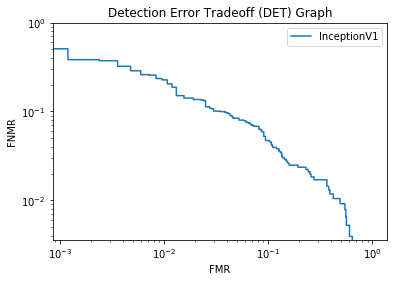

In [120]:
pseudo_main()